# 21M.387 Fundamentals of Music Processing
## Super Simple Kick/Snare Classifier

In this lecture, we introduce a number of general concepts used in audio signal processing and analysis by way of creating a simple classifier that can detect kick-drum and snare-drum hits.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact
import sys
sys.path.append("..")
import fmplib as fmp

plt.rcParams['figure.figsize'] = (12, 4)
fmp.documentation_button()

<img src="images/mir_basic_process.png">

<font color='red'>__Whiteboard__</font>: Windowing

Load an audio file with a simple kick / snare pattern.  
Remember that we will use an audio sampling rate of $F_s = 22050Hz$, and all audio data will be 1-channel (mono).

In [2]:
KICK_SNARE = 'audio/kick_snare.wav'
fs = 22050 # audio sampling rate (Hz)
x = fmp.load_wav(KICK_SNARE)

dur = len(x) / fs
print(f'length: {len(x)} samples')
print(f'duration: {dur:.2f} seconds')

length: 109847 samples
duration: 4.98 seconds


Plot:

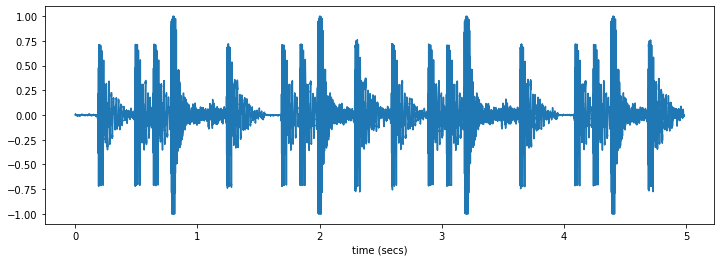

In [3]:
time = np.arange(len(x)) / fs
plt.figure()
plt.plot(time, x)
plt.xlabel("time (secs)");

Listen:

In [4]:
ipd.Audio(x, rate=fs)

Or, use this helper function from `fmplib.py`

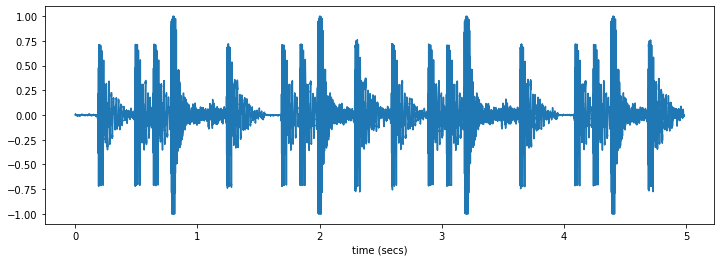

In [5]:
fmp.plot_and_listen(KICK_SNARE)

### Energy Feature

Raw audio samples by themselves are not that useful. To analyze them, we break up audio into a series of small chunks and derive some statistics about each chunk.

We call this chunk of audio a _window_. We analyze that window of audio. Then we move on to the next window.



In [6]:
# basic parameters: window length and hop_size (by how much to slide the window)
win_len = 200   # N
hop_size = 100  # H

Let's create a time-series for the energy for the above signal ($x$).

Assuming:  
The length of $x[n]$ is $L$.  
The window length is $N$.  
The hop size is $H$.  

How long is this energy signal? (Or, how many frames is the energy signal)

$$M = \lceil {L \over H} \rceil $$

In [7]:
# test some examples / edge cases:
test_lens = (550, 501, 500, 499, len(x))
for L in test_lens:
    M = fmp.calc_num_frames(L, hop_size)
    print(f'len(x) = {L}. num_frames = {M}')

len(x) = 550. num_frames = 6
len(x) = 501. num_frames = 6
len(x) = 500. num_frames = 5
len(x) = 499. num_frames = 5
len(x) = 109847. num_frames = 1099


$M$ is much less than the length of $x$.

Now, let's create this energy time-series (or energy feature, or energy signal). The energy for a chunk of audio of length $N$ is:

$E^x = \sum_{n=0}^{N-1} x[n]^2 $

The energy time-series with window length $N$ and hop size $H$ for the entire audio signal is:

$E^x[m] = \sum_{n=mH}^{mH+N-1} x(n)^2 $ for $m \in [0, M-1]$

We can also create a _normalized energy signal_, (or average energy signal) by dividing by the window length:

$\bar E^x[m] = \frac{1}{N} \sum_{n=mH}^{mH+N-1} x(n)^2 $ for $m \in [0, M-1]$

It is likely that we will run out of signal for the last few windows. In that case, zero-pad the end of $x[n]$ as needed.

In [8]:
energy = fmp.calc_energy(x, win_len, hop_size, False)
print(energy)
print(len(energy))

[2.67189415e-05 5.89120202e-06 7.85306096e-06 ... 3.81596899e-04
 2.63003763e-04 1.53066404e-05]
1099


Just one more tweak to the above forumla. It is preferable that the window is _centered_ around $n$. In other words:

$E^x = \sum_{n=-N/2}^{N/2-1} x[n]^2 $

<font color='red'>__Whiteboard__</font>: Centered Window

We can achieve this effect in code by zero-padding the beginning of $x$ with $N/2$ zeros

In [9]:
N = 10
H = 5
win1 = np.zeros(20)
win1[:N] = 1
win2 = np.zeros(20)
win2[H:N+H] = 1.1

@interact(show_windows=False, zero_pad=False)
def plotit(show_windows=False, zero_pad=False):
    xx = np.array([.1,0,-.1,0,.1,.2,.8,-.7,.9,-.6,.7,-.8, .5, .2, -.7, -.1, .8, .3, -.5, -.1, .4, -.3, 0,0,0,0])

    if zero_pad:
        xx = np.concatenate((np.zeros(N//2), xx))
    
    plt.figure()
    plt.stem(xx, basefmt='black')
    if show_windows:
        plt.plot(win1, 'r')
        plt.plot(win2, 'g')
    plt.ylim(-1.5, 1.5)
    plt.xlim(0, 25)
    plt.title('{}, N=10, H=5'.format(['non-centered', 'centered with zero-padding'][zero_pad]))
    plt.show()


interactive(children=(Checkbox(value=False, description='show_windows'), Checkbox(value=False, description='ze…

### Sidebar: 0-base indexing vs 1-base indexing

Warning: some mathematical formulas (as found in text books) are 0-base indexed, like $\sum_{n=0}^{N-1}x[n]$.  Others are 1-base indexed, like $\sum_{l=1}^{L}C(n_l, m_l)$.

In code, Matlab indexing is 1-base. But python (and C-based languages) is 0-base. When iterating through a list in python, or slicing an array, the endpoint is not included.

### Back to the Energy Signal

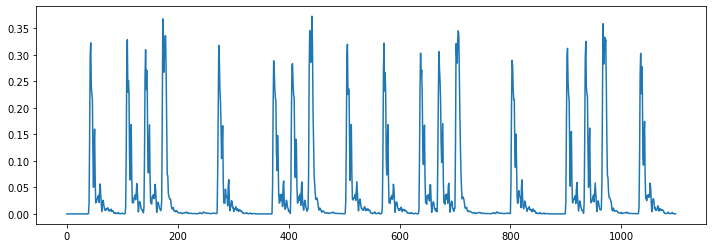

In [10]:
plt.figure()
plt.plot(energy);

This energy signal is a time-series, just like the original audio, but it has a much lower implied sampling rate. This rate, sometimes called the _feature rate_ or _feature frequency_ is $F_f = \frac{F_s}{H}$ samples per second.

In [11]:
ff = fs / hop_size
print(f'{ff:.3f}Hz')

220.500Hz


Let's see how this energy function changes with different values of $N$ and $H$.

In [12]:
@interact(win_len=fmp.slider(100,2000), hop_size=fmp.slider(100,1000))
def plot_energy(win_len=200, hop_size=100):
    e = fmp.calc_energy(x, win_len, hop_size, centered=True)
    plt.figure()
    plt.plot(e)
    plt.show()

interactive(children=(IntSlider(value=100, continuous_update=False, description='win_len', max=2000, min=100),…

Reasonable values for $N$ and $H$ seem to be:  
$N=1000$  
$H=500$


In [13]:
win_len = 1000
hop_size = 500

### Onset Detection

From this energy signal, we can try to locate note onsets. We look for a sharp increase in energy. We can measure an increase by looking for a positive derivative of the signal, and setting the negative derivative to 0. We call this an "Energy Novelty Function":

$$\Delta[n] = \vert E^x[n+1] - E^x[n] \vert_{\ge 0}$$

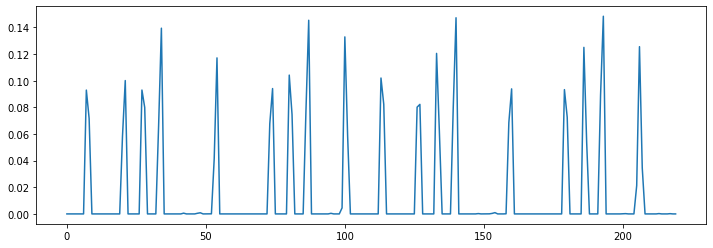

In [14]:
def calc_enf(e):
    pass
# [livecode]
    N = len(e) - 1
    out = np.zeros(N)
    for n in range(N):
        out[n] = max(0, e[n+1] - e[n])
    return out
# [livecode]

energy = fmp.calc_energy(x, win_len, hop_size)
enf = calc_enf(energy)

plt.figure()
plt.plot(enf);

### Sidebar: Optimization

How long does it take to run `calc_enf(x)`?  
We can use `%timeit` to find out how long it takes

In [15]:
%timeit -n1000 calc_enf(energy)

164 µs ± 8.42 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Let's use list comprehension!

In [16]:
def calc_enf(e):
    pass
# [livecode]
    N = len(e) - 1
    return np.array( [max(0, e[n+1] - e[n]) for n in range(N)] )
# [livecode]

In [17]:
%timeit -n1000 calc_enf(energy)

171 µs ± 18.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


How about using `if` instead of `max`?

In [18]:
def calc_enf(e):
    pass
# [livecode]
    N = len(e) - 1
    out = np.zeros(N)
    for n in range(N):
        d = e[n+1] - e[n]
        if d > 0:
            out[n] = d
    return out
# [livecode]


In [19]:
%timeit -n1000 calc_enf(energy)

115 µs ± 6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Let's avoid python loops altogether

In [20]:
def calc_enf(e):
    pass
# [livecode]    
    de = e[1:] - e[:-1]
    de[de<0] = 0
    return de
# [livecode]

In [21]:
%timeit -n1000 calc_enf(energy)

4.42 µs ± 651 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Back to $\Delta[n]$

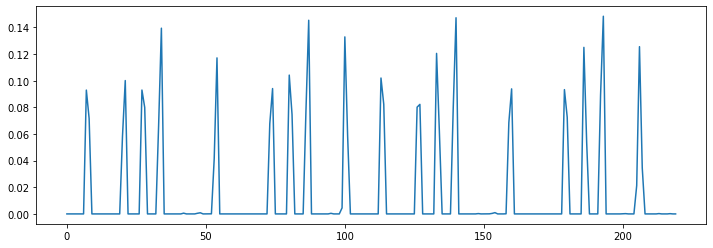

In [22]:
energy = fmp.calc_energy(x, win_len, hop_size)
enf = calc_enf(energy)

plt.figure()
plt.plot(enf);

The onsets are peaks of this function. Peak-picking is often done as one of the stages in an audio processing algorithm. The simplest form looks for local maxima:

$P = (p_1, p_2, \cdots, p_L)$ is a set of peaks of $x[n]$ where $p_n$ is a peak if:
$$ x[p_n] > x[p_n - 1] \wedge x[p_n] > x[p_n + 1] $$


Applying peak peaking

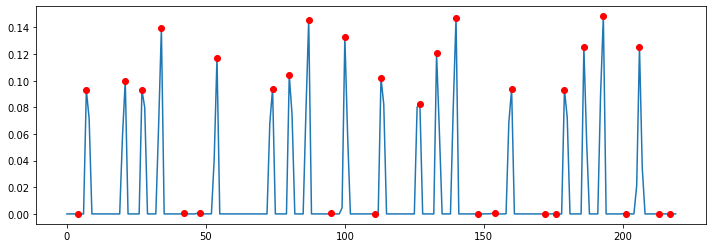

In [23]:
energy = fmp.calc_energy(x, win_len, hop_size)
enf = calc_enf(energy)
onsets = fmp.find_peaks(enf)

plt.figure()
plt.plot(enf)
plt.plot(onsets, enf[onsets], 'ro');

Hmmm. Too many peaks found. We only want the big ones, so only keep a peak if:
$$ x[p_n] > \max( x[n] ) \cdot \rho $$ 
where $\rho \in [0, 1]$ is a threshold parameter.

Try Again with $ \rho = 0.10 $

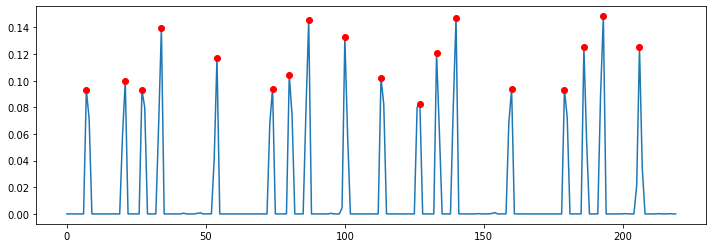

In [24]:
onsets = fmp.find_peaks(enf, .1)
plt.figure()
plt.plot(enf)
plt.plot(onsets, enf[onsets], 'ro');
plt.show()

Listen to the original audio against synthesized audio with clicks at peak locations

In [25]:
display(ipd.Audio(x, rate=fs))
c = fmp.make_clicks(onsets*hop_size)
display(ipd.Audio(c, rate=22050))

### Zero Crossing Feature

Another statistic we can calculate for a window of audio is known as the zero-crossing-rate: How many times the audio waveform crosses "0". 

<font color='red'>__Whiteboard__</font>: Zero Crossing

Here is some code that does this.

In [26]:
def num_zerocrossings(x) :
    pass
# [livecode]
    count = 0
    for i in range(len(x)-1) :
        if (x[i] > 0 and x[i+1] <= 0) or (x[i] < 0 and x[i+1] >=0):
            count += 1
    return count
# [livecode]

Let's test it on a window of audio.

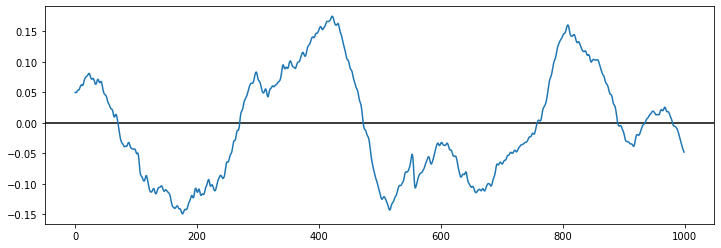

In [27]:
x_test = x[7000:8000] # a small window of 1000 samples

plt.figure()
plt.axhline(0, color='black')
plt.plot(x_test);

In [28]:
print(num_zerocrossings(x_test))

7


It works!

It can also be optimized. This will be a pset exercise.

Like we did with energy, let's create a (normalized) zc-feature with the same parameters:  
$N=1000$  
$H=500$


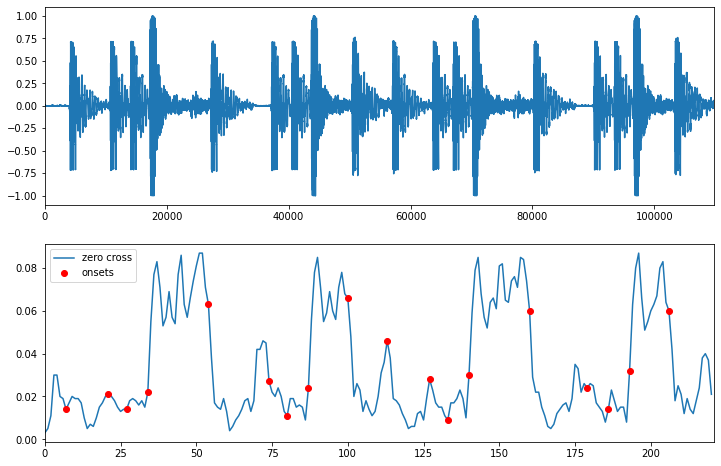

In [29]:
zc = fmp.calc_zc(x, win_len, hop_size)

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(x)
plt.xlim(0, len(x))
plt.subplot(2,1,2)
plt.plot(zc)
plt.plot(onsets, zc[onsets], 'ro');
plt.legend(('zero cross', 'onsets'))
plt.xlim(0, len(zc));

In [30]:
ipd.Audio(x, rate=fs)

What can we observe from this plot?

- the discriminating information is in the zc-rate __after__ an onset
- kicks generally have a medium zc-rate at the beginning and low zc-rate later
- snares have a higher zc-rate
- Why?


### Classification of onsets

Now that we detected the onsets, we classify them as either snares or kicks using the zero-cross feature.

Let's compute the accumulated zc-signal over a small window of time (say 150ms) _after_ the onset.

In [31]:
# what is the inspection window size (in samples)?
note_win_len = 0 # ??
# [livecode]
ff = fs / hop_size
print(f'feature rate: {ff} Hz')

note_win_len = int(round(.150 * ff))
print('window len:', note_win_len)

feature rate: 44.1 Hz
window len: 7


In [32]:
def calc_ave_at_onset(onsets, x, w_len) :
    "for each onset, return the average value of x for a window of length w_len"
    
    # create the output vector
    output = np.empty(len(onsets))

    for i,p in enumerate(onsets):
        output[i] = np.sum(x[p : p+w_len]) / float(w_len)

    return output

hit_value = calc_ave_at_onset(onsets, zc, note_win_len)

And now, let's have a look:

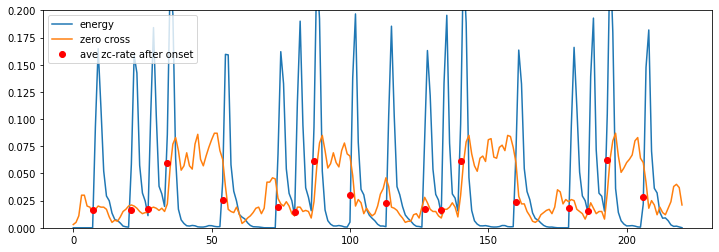

In [33]:
plt.figure()
plt.plot(energy)
plt.plot(zc)
plt.plot(onsets, hit_value, 'ro')
plt.legend(('energy', 'zero cross', 'ave zc-rate after onset'))
plt.ylim(0, .2);

Let's package it all up as one function:

In [34]:
def kick_snare_detection(filepath) :
    fs = 22050

    win_len = 1000
    hop_size = 500
    peaks_thresh = .10
    win_len_sec = .150
    note_win_len = int(round(win_len_sec * fs / hop_size))
    
    x = fmp.load_wav(filepath)
    energy = fmp.calc_energy(x, win_len, hop_size)
    enf = calc_enf(energy)
    zc = fmp.calc_zc(x, win_len, hop_size)
    onsets = fmp.find_peaks(enf, peaks_thresh)
    hit_value = calc_ave_at_onset(onsets, zc, note_win_len)
    
    # show results
    plt.figure(figsize=(14,3))
    plt.plot(x)
    plt.xlim(0, len(x))
    plt.figure(figsize=(14,3))
    ratio = np.max(zc) / np.max(energy)
    plt.plot(energy * ratio)
    plt.plot(zc)
    plt.plot(onsets, hit_value, 'ro')
    plt.legend(('energy', 'zero cross', 'ave zc at onset'))
    plt.xlim(0, len(energy))
    
    # play audio 
    return ipd.Audio(x, rate=fs)

Try another audio file:

In [35]:
TEST_REC = 'audio/thump_clap.wav'

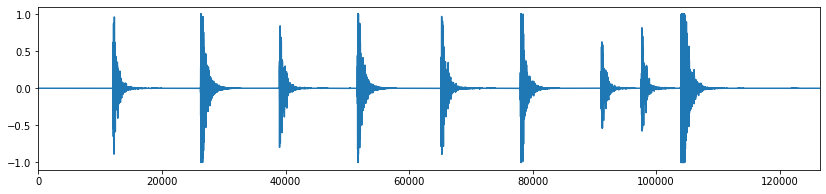

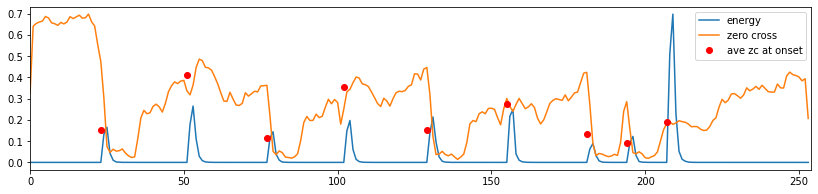

In [36]:
kick_snare_detection(TEST_REC)

### Conclusion

- This is a fun and simple introduction to many audio processing concepts: windowing, feature extraction, signal pipeline, etc...
- Energy measurement can be improved.
- Onset detection function can be improved.
- Zero-crossing is a "cheap feature", but the main idea behind it, signal frequency, can be calculated in a more sophisticated way.